In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
#数据集的加载
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
#如果在Windows下运行或者运行时出现 BrokenPipeError ，那么将num_workers=0.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Files already downloaded and verified


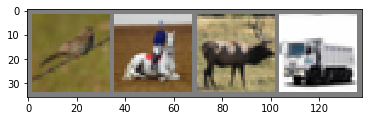

 birdhorse deertruck


In [9]:
#查看训练图片
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
#获取随机的训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

#显示图片
imshow(torchvision.utils.make_grid(images))

#输出标签
print(''.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
#定义一个卷积网络
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    
net = Net()

In [12]:
#定义损失函数和优化器，这里使用的是 CrossEntropyloss 损失 和带栋梁的 SGD 梯度下降法
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [15]:
#训练网络
for epoch in range(2):   #多次遍历数据集
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #输入训练集，data 是一个 list ，为 [inputs, labels]
        inputs, labels = data

        #梯度区域的缓冲清零
        optimizer.zero_grad()
        
        #前向传播 + 反向传播 + 梯度下降
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #打印训练过程
        running_loss += loss.item()
        if i % 2000 == 1999:  # 每2000个mini-batches输出一次
            print('[%d, %5d] loss: %.3f' %
                   (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')
                        

[1,  2000] loss: 2.201
[1,  4000] loss: 1.871
[1,  6000] loss: 1.661
[1,  8000] loss: 1.567
[1, 10000] loss: 1.498
[1, 12000] loss: 1.474
[2,  2000] loss: 1.402
[2,  4000] loss: 1.389
[2,  6000] loss: 1.338
[2,  8000] loss: 1.315
[2, 10000] loss: 1.282
[2, 12000] loss: 1.286
Finished Training


In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

tensor([3, 8, 8, 0])


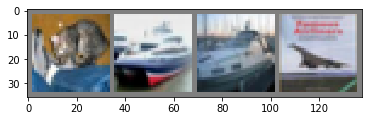

GroundTruth:   cat ship shipplane


In [30]:
#显示测试集中的图像
dataiter = iter(testloader)
images, labels = dataiter.next()
print(labels)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',''.join('%5s' % classes[labels[j]] for j in range(4)))

In [28]:
#加载保持的模型,（注意：这里不需要保存和重新加载保存模型，只是说明如何这样做）
#net = Net()
#net.load_state_dict(torch.load(PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [29]:
outputs = net(images)
print(outputs)

tensor([[ 0.1346, -1.0120,  0.2305,  2.7303, -2.2630,  1.3634,  0.0775, -1.8142,
          2.0745, -1.2890],
        [ 4.2346,  6.0286, -1.0810, -3.8150, -3.5004, -3.9912, -3.9635, -4.4664,
          6.0068,  3.7298],
        [ 1.6823,  2.9036,  0.3061, -1.1951, -2.0749, -1.5082, -2.6141, -1.7928,
          2.9378,  2.0985],
        [ 2.1259,  0.8532,  0.6808, -0.5829, -0.1560, -1.6023, -2.0704, -1.5216,
          1.5778,  0.3192]], grad_fn=<AddmmBackward>)


In [32]:
#输出预测概率最高的一类，因为对一张图片输出的outputs是一个1*10的概率矩阵,这里测试的只是1*4的图片
_, predicted = torch.max(outputs, 1)
print(predicted)

print('predicted:', ''.join('%5s' % classes[predicted[j]]
                            for j in range(4)))

tensor([3, 1, 8, 0])
predicted:   cat  car shipplane


In [33]:
#接下来测试网络在整个测试集的表现
correct = 0 
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [34]:
#看起来不错，接下来看看在每一类的测试集表现如何
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
       classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 51 %
Accuracy of   car : 74 %
Accuracy of  bird : 34 %
Accuracy of   cat : 40 %
Accuracy of  deer : 42 %
Accuracy of   dog : 56 %
Accuracy of  frog : 67 %
Accuracy of horse : 60 %
Accuracy of  ship : 76 %
Accuracy of truck : 56 %
